In [5]:
def read_file(filename):
    with open(filename, encoding="utf-8") as input_file:
        text = input_file.read()
    return text

In [6]:
import tqdm

site_texts = []
pages = [1 + i for i in range(300)]
        
for i in tqdm.tqdm(pages):
    name = f'sheets/sheet_{i}.txt'
    site_texts.append(read_file(name))
    
print(f"Прочитано {len(site_texts)} файлов.")

100%|██████████| 300/300 [00:14<00:00, 20.47it/s]

Прочитано 300 файлов.


In [7]:
from bs4 import BeautifulSoup
import re
import pandas as pd
from dateutil.parser import parse
from datetime import datetime, date, time

def parse_tag(tag, tag_value, item):
    key = tag
    value = "None"
    if item.find('div', {'class': tag_value}):
        if key == 'link':
            value = item.find('div', {'class': tag_value}).find('a').get('href')
        elif (key == 'price' or key == 'price_meter'):
            value = parse_digits(item.find('div', {'class': tag_value}).text, key)
        elif key == 'pub_datetime':
            value = parse_date(item.find('div', {'class': tag_value}).text)
        else:
            value = item.find('div', {'class': tag_value}).text
    return key, value


def parse_digits(string, type_digit):
    digit = 0
    try:
        if type_digit == 'flats_counts':
            digit = int(re.sub(r" ", "", string[:string.find("пр")]))
        elif type_digit == 'price':
            digit = int(re.sub(r"", "", re.sub(r"₽", " ", string)))
        elif type_digit == 'price_meter':
            digit = re.sub(r" ", "", re.sub(r"₽/м²", "", string))
    except:
        return -1
    return digit

def parse_date(string):
    now = datetime.strptime("25.07.24, 00:00", "%d.%m.%y, %H:%M")
    s = string
    if string.find('сегодня') >= 0:
        s = "{} {}".format(now.day, now.strftime("%b"))
        s = string.replace('сегодня', s)
    elif string.find('вчера') >= 0:
        s = "{} {}".format(now.day - 1, now.strftime("%b"))
        s = string.replace('вчера',s) 
    if (s.find('июл') > 0):
        s = s.replace('июл','july')
    if (s.find('июн') > 0):
        s = s.replace('июн','june')
    if (s.find('май') > 0):
        s = s.replace('май','may')
    return parse(s).strftime('%Y-%m %H:%M')
    
    
def parse_text(text, index):
    
    tag_table = '_93444fe79c--wrapper--W0WqH'
    tag_items = ['_93444fe79c--card--ibP42 _93444fe79c--wide--gEKNN']
    tag_flats_counts = '_93444fe79c--header--BEBpX' 
    tags = {
        'link':('_93444fe79c--container--kZeLu _93444fe79c--link--DqDOy'),
        'desc': ('_93444fe79c--row--kEHOK'),
        'complex': ('_93444fe79c--container--aWzpE'),
        'price': ('_93444fe79c--container--aWzpE'),
        'price_meter': '_93444fe79c--color_gray60_100--mYFjS _93444fe79c--lineHeight_20px--fX7_V _93444fe79c--fontWeight_normal--JEG_c _93444fe79c--fontSize_14px--reQMB _93444fe79c--display_block--KYb25 _93444fe79c--text--e4SBY _93444fe79c--text_letterSpacing__normal--tfToq',
        'metro': ('_93444fe79c--container--w7txv', '_93444fe79c--link--BwwJO'),
        'pub_datetime':'_93444fe79c--absolute--yut0v', 
        'address': '_93444fe79c--labels--L8WyJ',
        'square': '_93444fe79c--row--kEHOK'
    }
    
    res = []
    flats_counts = 0
    soup = BeautifulSoup(text)  
    if soup.find('div', {'class': tag_flats_counts}):
        flats_counts = parse_digits(soup.find('div', {'class': tag_flats_counts}).text, 'flats_counts')
   
    flats_list = soup.find('div', {'class': tag_table}) 
    if flats_list:
        items = flats_list.find_all('div', {'class': tag_items})         
        for i, item in enumerate(items):
            
            d = {'index': index}
            index += 1
            for tag in tags.keys():
                tag_value = tags[tag]
                key, value = parse_tag(tag, tag_value, item)
                d[key] = value
            results[index] = d
        
    return flats_counts, index



In [16]:
from IPython.display import clear_output

sum_flats = 0
index = 0
results = {}
for i, text in enumerate(site_texts):
    flats_counts, index = parse_text(text, index)    
    sum_flats = len(results)
    clear_output(wait=True)
    print(f" Файл {i + 1} flats = {flats_counts}, добавлено итого {sum_flats} квартир")
print(f"Итого sum_flats ({sum_flats}) = flats_counts({flats_counts})")

 Файл 300 flats = -1, добавлено итого 4500 квартир
Итого sum_flats (4500) = flats_counts(-1)


In [17]:
import pandas as pd
col = ('index','link','desc','complex', 'price', 'price_meter', 'address', 'metro','pub_datetime', 'square')
df_1 = pd.DataFrame(results)
df_1.to_csv('flats.csv')

In [18]:
import pandas as pd

df_1 = pd.read_csv('flats.csv', index_col=0)
df_1.shape

(10, 4500)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 1 to 4500
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         4500 non-null   object
 1   link          4500 non-null   object
 2   desc          4500 non-null   object
 3   complex       4500 non-null   object
 4   price         4500 non-null   object
 5   price_meter   4500 non-null   int32 
 6   metro         4500 non-null   object
 7   pub_datetime  4500 non-null   object
 8   address       4500 non-null   object
 9   square        4500 non-null   object
dtypes: int32(1), object(9)
memory usage: 498.2+ KB


In [29]:
df['square'] = df['square'].astype(int)
df['price'] = df['price'].astype(int)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 1 to 4500
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         4500 non-null   object
 1   link          4500 non-null   object
 2   desc          4500 non-null   object
 3   complex       4500 non-null   object
 4   price         4500 non-null   int32 
 5   price_meter   4500 non-null   int32 
 6   metro         4500 non-null   object
 7   pub_datetime  4500 non-null   object
 8   address       4500 non-null   object
 9   square        4500 non-null   int32 
dtypes: int32(3), object(7)
memory usage: 463.0+ KB


In [32]:
df.head(10)

,index,link,desc,complex,price,price_meter,metro,pub_datetime,address,square
1,0,https://kazan.cian.ru/sale/flat/300752684/,"3-комн. квартира, 75,21 м², 18/19 этажСекция 2...",ЖК «Светлая долина»,37900050,505334,Горки8 минут на транспорте,2024-07 17:22,"Республика Татарстан, Казань, р-н Советский, м...",75
2,1,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,25717320,428622,Горки8 минут на транспорте,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60
3,2,https://kazan.cian.ru/sale/flat/301019028/,"3-комн. квартира, 75,29 м², 2/17 этажСекция 6 ...",ЖК «Мой Ритм»,37018950,493586,Горки4 минуты на транспорте,2024-07 19:31,"Республика Татарстан, Казань, р-н Советский, м...",75
4,3,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,49591575,367345,Суконная слобода4 минуты на транспорте,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
5,4,https://kazan.cian.ru/sale/flat/304842045/,"3-комн. квартира, 78,62 м², 2/5 этажСекция 1 •...",ЖК «Дом на Исхаки»,39598962,507679,Кремлёвская11 минут пешком,2024-07 16:56,"Республика Татарстан, Казань, р-н Вахитовский,...",78
6,5,https://kazan.cian.ru/sale/flat/300939000/,"3-комн. квартира, 67 м², 3/18 этажСекция 3 • С...",ЖК «Парк Маяк»,26285105,392315,Аметьево9 минут на транспорте,2024-06 10:38,"Республика Татарстан, Казань, р-н Приволжский,...",67
7,6,https://kazan.cian.ru/sale/flat/300939527/,"3-комн. квартира, 63,2 м², 2/14 этажСекция 2 •...",ЖК «Фермаполис»,11714787,185949,Проспект Победы7 минут на транспорте,2024-07 05:18,"Республика Татарстан, Казань, р-н Приволжский,...",63
8,7,https://kazan.cian.ru/sale/flat/304046764/,"3-комн. квартира, 87,68 м², 14/18 этажСдача ко...",ЖК «Savin Family»,49990287,574601,Козья слобода4 минуты на транспорте,2024-07 21:34,"Республика Татарстан, Казань, р-н Ново-Савинов...",87
9,8,https://kazan.cian.ru/sale/flat/285910858/,"3-комн. квартира, 71,06 м², 4/15 этажСекция 3 ...",ЖК «Яналиф»,12723981,179211,Площадь Тукая4 минуты на транспорте,2024-07 15:37,"Республика Татарстан, Казань, р-н Вахитовский,...",71
10,9,https://kazan.cian.ru/sale/flat/304244356/,"3-комн. квартира, 73,24 м², 15/25 этажСекция 1...",ЖК «Яратам»,32235705,441585,Горки3 минуты на транспорте,2024-07 18:42,"Республика Татарстан, Казань, р-н Советский, м...",73


In [33]:
df['metro'] = df['metro'].str.split('1').str[0]
df['metro'] = df['metro'].str.split('2').str[0]
df['metro'] = df['metro'].str.split('3').str[0]
df['metro'] = df['metro'].str.split('4').str[0]
df['metro'] = df['metro'].str.split('5').str[0]
df['metro'] = df['metro'].str.split('7').str[0]
df['metro'] = df['metro'].str.split('8').str[0]
df['metro'] = df['metro'].str.split('9').str[0]
df.head()

,index,link,desc,complex,price,price_meter,metro,pub_datetime,address,square
1,0,https://kazan.cian.ru/sale/flat/300752684/,"3-комн. квартира, 75,21 м², 18/19 этажСекция 2...",ЖК «Светлая долина»,37900050,505334,Горки,2024-07 17:22,"Республика Татарстан, Казань, р-н Советский, м...",75
2,1,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,25717320,428622,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60
3,2,https://kazan.cian.ru/sale/flat/301019028/,"3-комн. квартира, 75,29 м², 2/17 этажСекция 6 ...",ЖК «Мой Ритм»,37018950,493586,Горки,2024-07 19:31,"Республика Татарстан, Казань, р-н Советский, м...",75
4,3,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,49591575,367345,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
5,4,https://kazan.cian.ru/sale/flat/304842045/,"3-комн. квартира, 78,62 м², 2/5 этажСекция 1 •...",ЖК «Дом на Исхаки»,39598962,507679,Кремлёвская,2024-07 16:56,"Республика Татарстан, Казань, р-н Вахитовский,...",78


In [34]:
df['metro'].unique()

array(['Горки', 'Суконная слобода', 'Кремлёвская', 'Аметьево',
       'Проспект Победы', 'Козья слобода', 'Площадь Тукая'], dtype=object)

In [35]:
df.dtypes

index           object
link            object
desc            object
complex         object
price            int32
price_meter      int32
metro           object
pub_datetime    object
address         object
square           int32
dtype: object

In [36]:
df.describe()


,price,price_meter,square
count,4.500000e+03,4500.000000,4500.000000
mean,3.085793e+07,392424.530667,78.466667
std,1.473558e+07,159362.324267,17.104987
min,6.974160e+06,115212.000000,60.000000
25%,1.909069e+07,253947.250000,67.000000
50%,2.955390e+07,391442.500000,75.000000
75%,4.022817e+07,532372.500000,84.000000
max,8.956494e+07,666963.000000,135.000000


In [37]:
import matplotlib
import matplotlib.pyplot as plt 

In [38]:
matplotlib.rcParams.update({'font.size': 14})

In [39]:
print(matplotlib.__version__)

3.7.5


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'price_meter'}>],
       [<Axes: title={'center': 'square'}>, <Axes: >]], dtype=object)

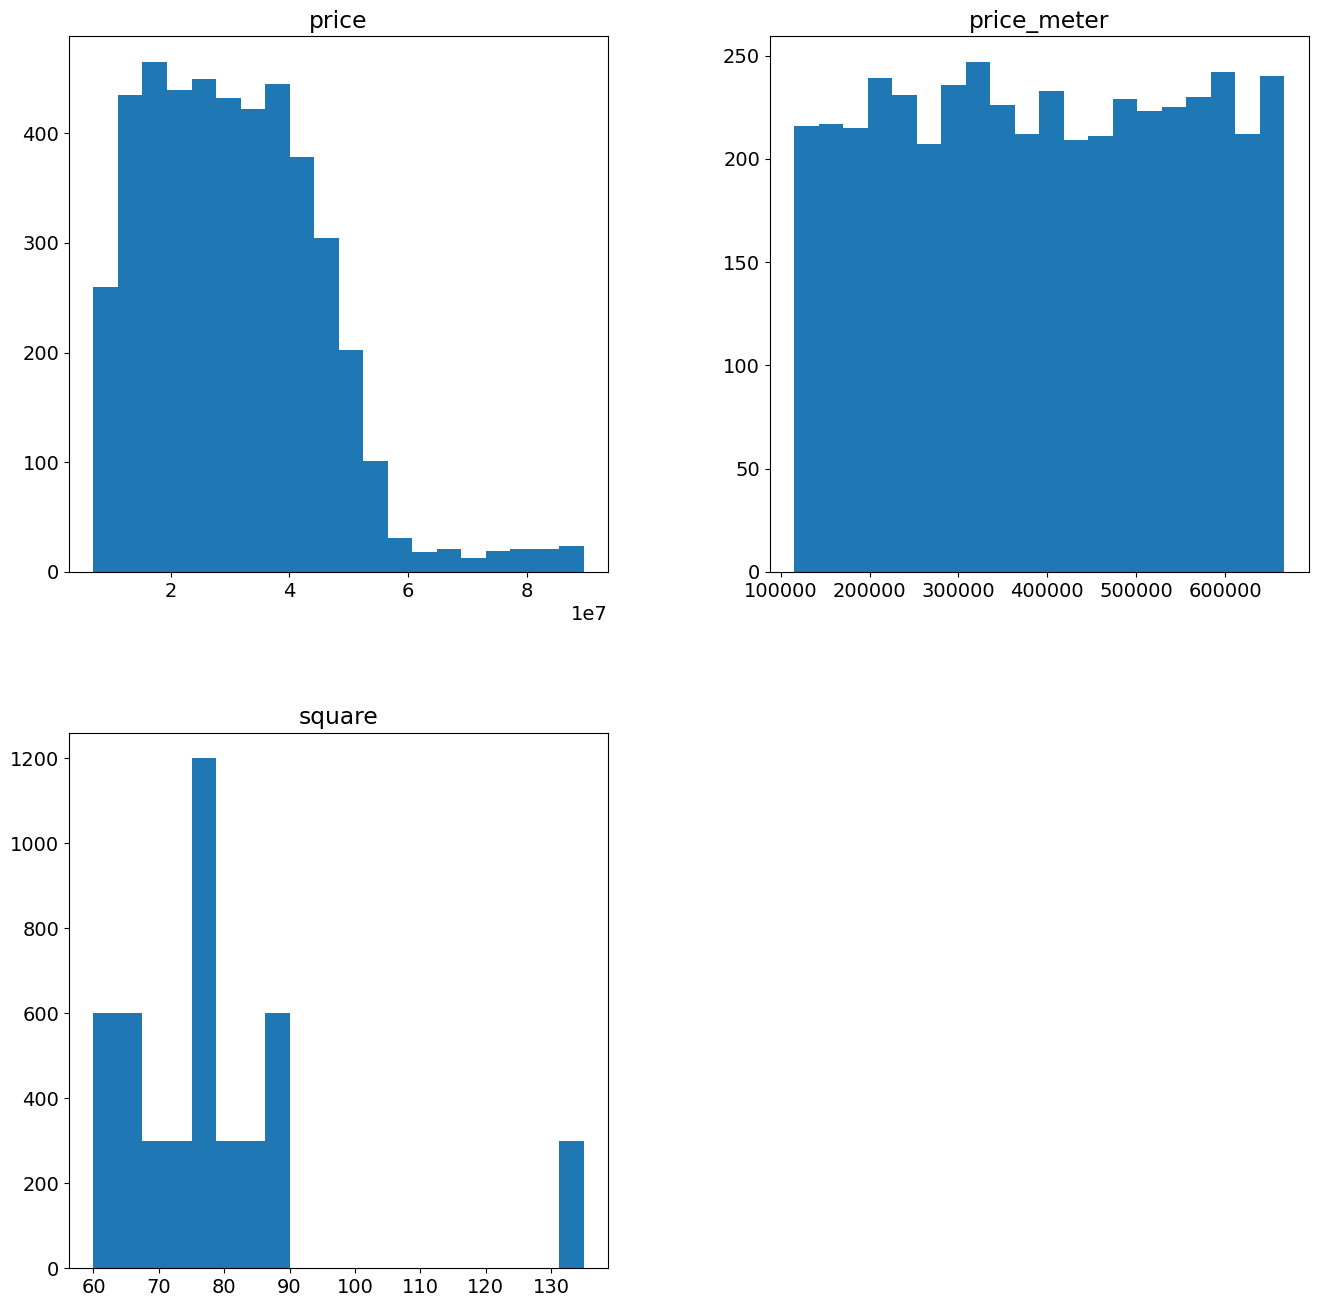

In [40]:
df.hist(figsize=(16,16), bins=20, grid=False)

In [41]:
df['price'].describe()

count    4.500000e+03
mean     3.085793e+07
std      1.473558e+07
min      6.974160e+06
25%      1.909069e+07
50%      2.955390e+07
75%      4.022817e+07
max      8.956494e+07
Name: price, dtype: float64

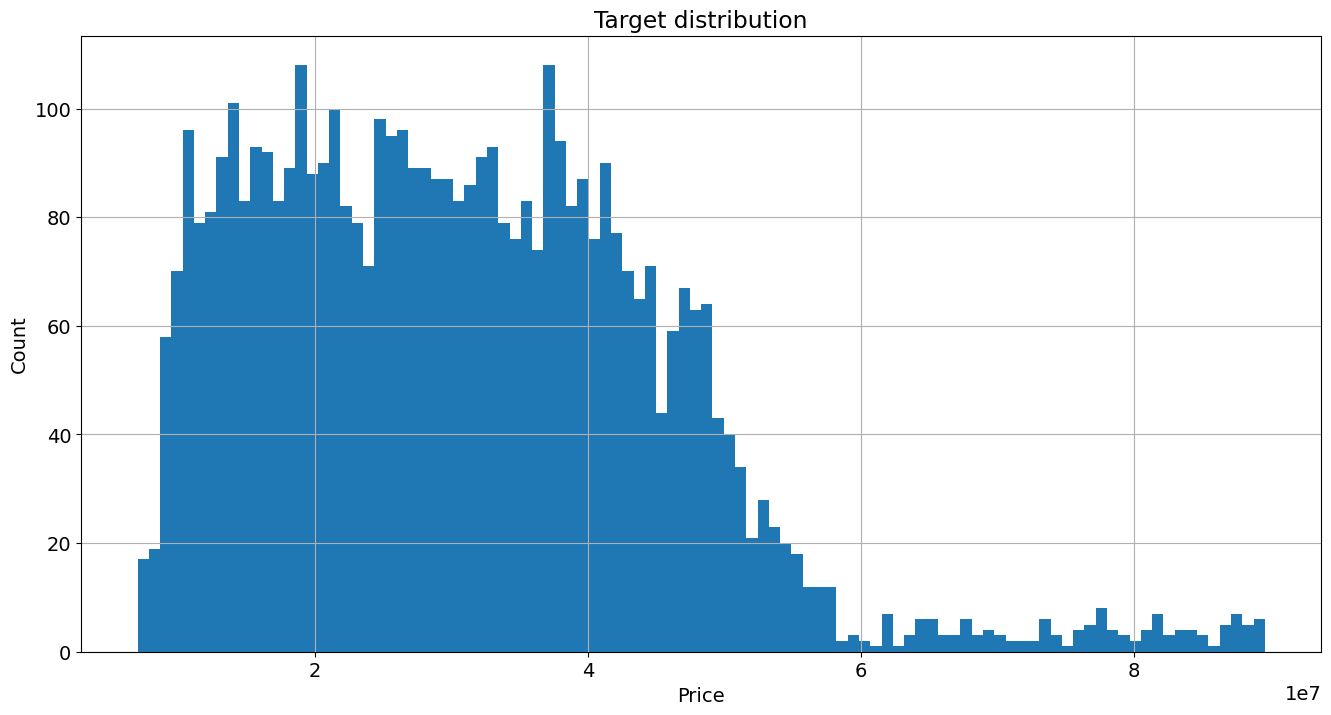

In [42]:
#Исследование целевой переменной
plt.figure(figsize=(16,8))

df['price'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [43]:
import seaborn as sns

<Axes: ylabel='price'>

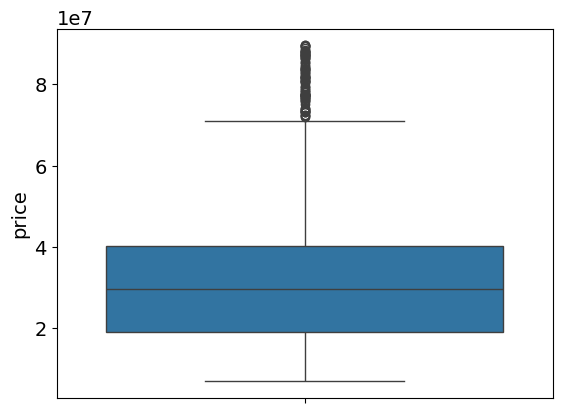

In [44]:
sns.boxplot(df.price)

In [45]:
sorted_data = df[df['price']>70000000].sort_values(by='price', ascending=False)
sorted_data.head(100)

,index,link,desc,complex,price,price_meter,metro,pub_datetime,address,square
1234,1233,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,89564940,663444,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
3229,3228,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,89549010,663326,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
2539,2538,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,89458560,662656,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
919,918,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,89414280,662328,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
694,693,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,89389035,662141,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
...,...,...,...,...,...,...,...,...,...,...
829,828,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,71965530,533078,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
2194,2193,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,70984215,525809,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
2629,2628,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,70949655,525553,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
3379,3378,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,70441785,521791,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135


array([[<Axes: title={'center': 'Аметьево'}>,
        <Axes: title={'center': 'Горки'}>,
        <Axes: title={'center': 'Козья слобода'}>],
       [<Axes: title={'center': 'Кремлёвская'}>,
        <Axes: title={'center': 'Площадь Тукая'}>,
        <Axes: title={'center': 'Проспект Победы'}>],
       [<Axes: title={'center': 'Суконная слобода'}>, <Axes: >, <Axes: >]],
      dtype=object)

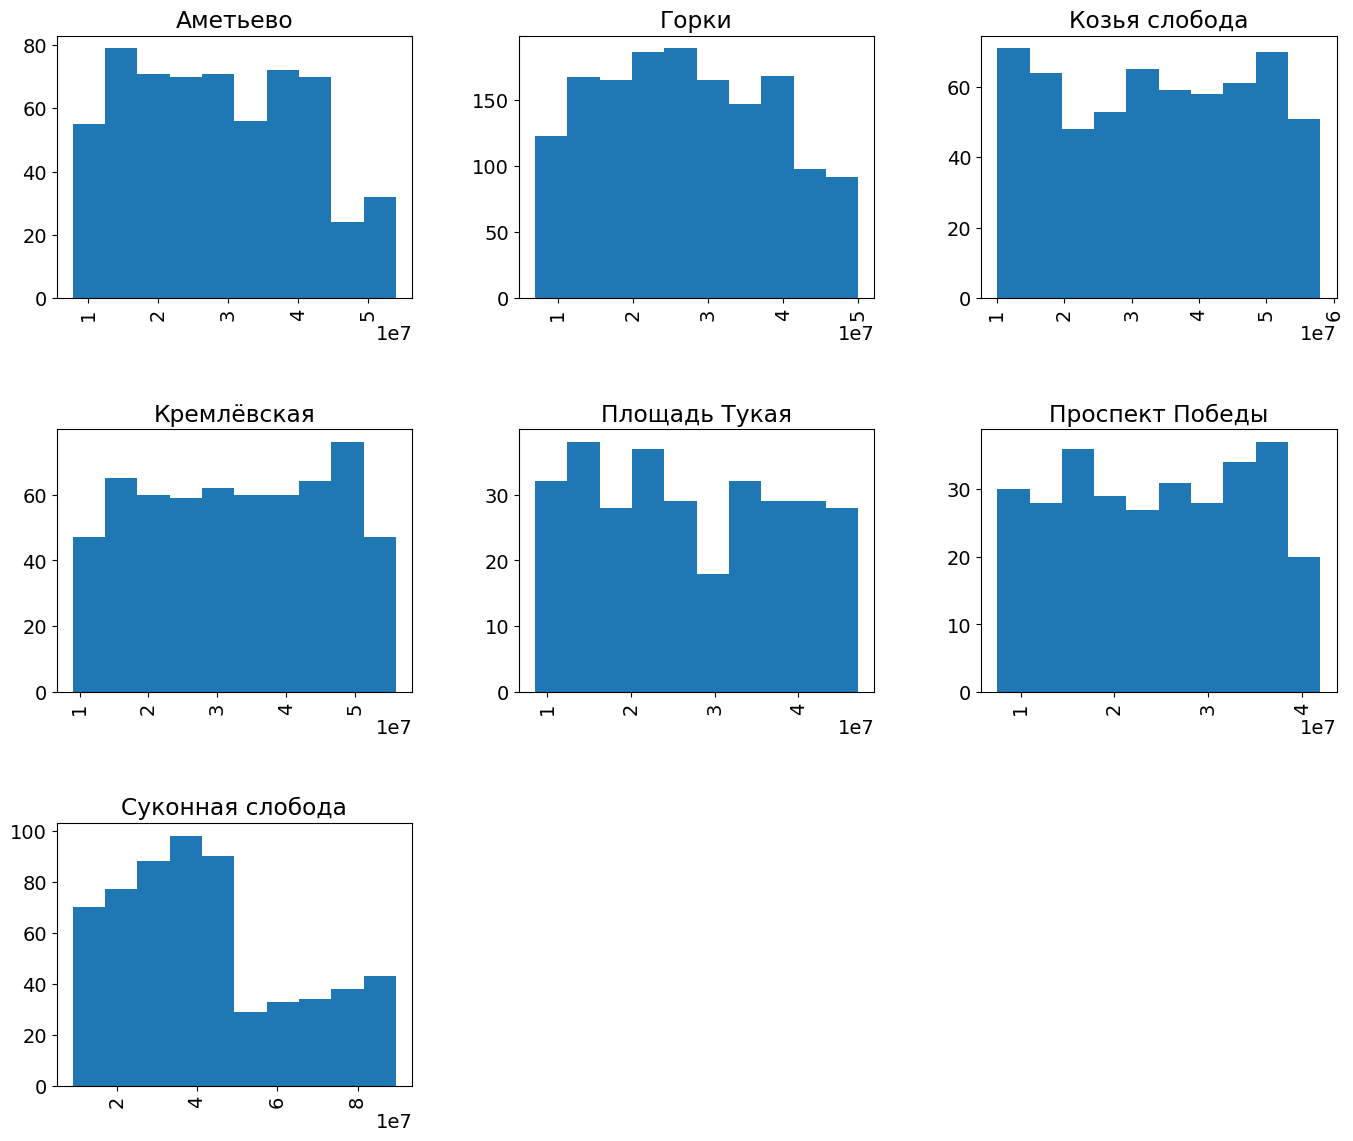

In [46]:
hists = df['price'].hist(by=df['metro'], figsize=(16, 14), color = "tab:blue", grid = True)
hists

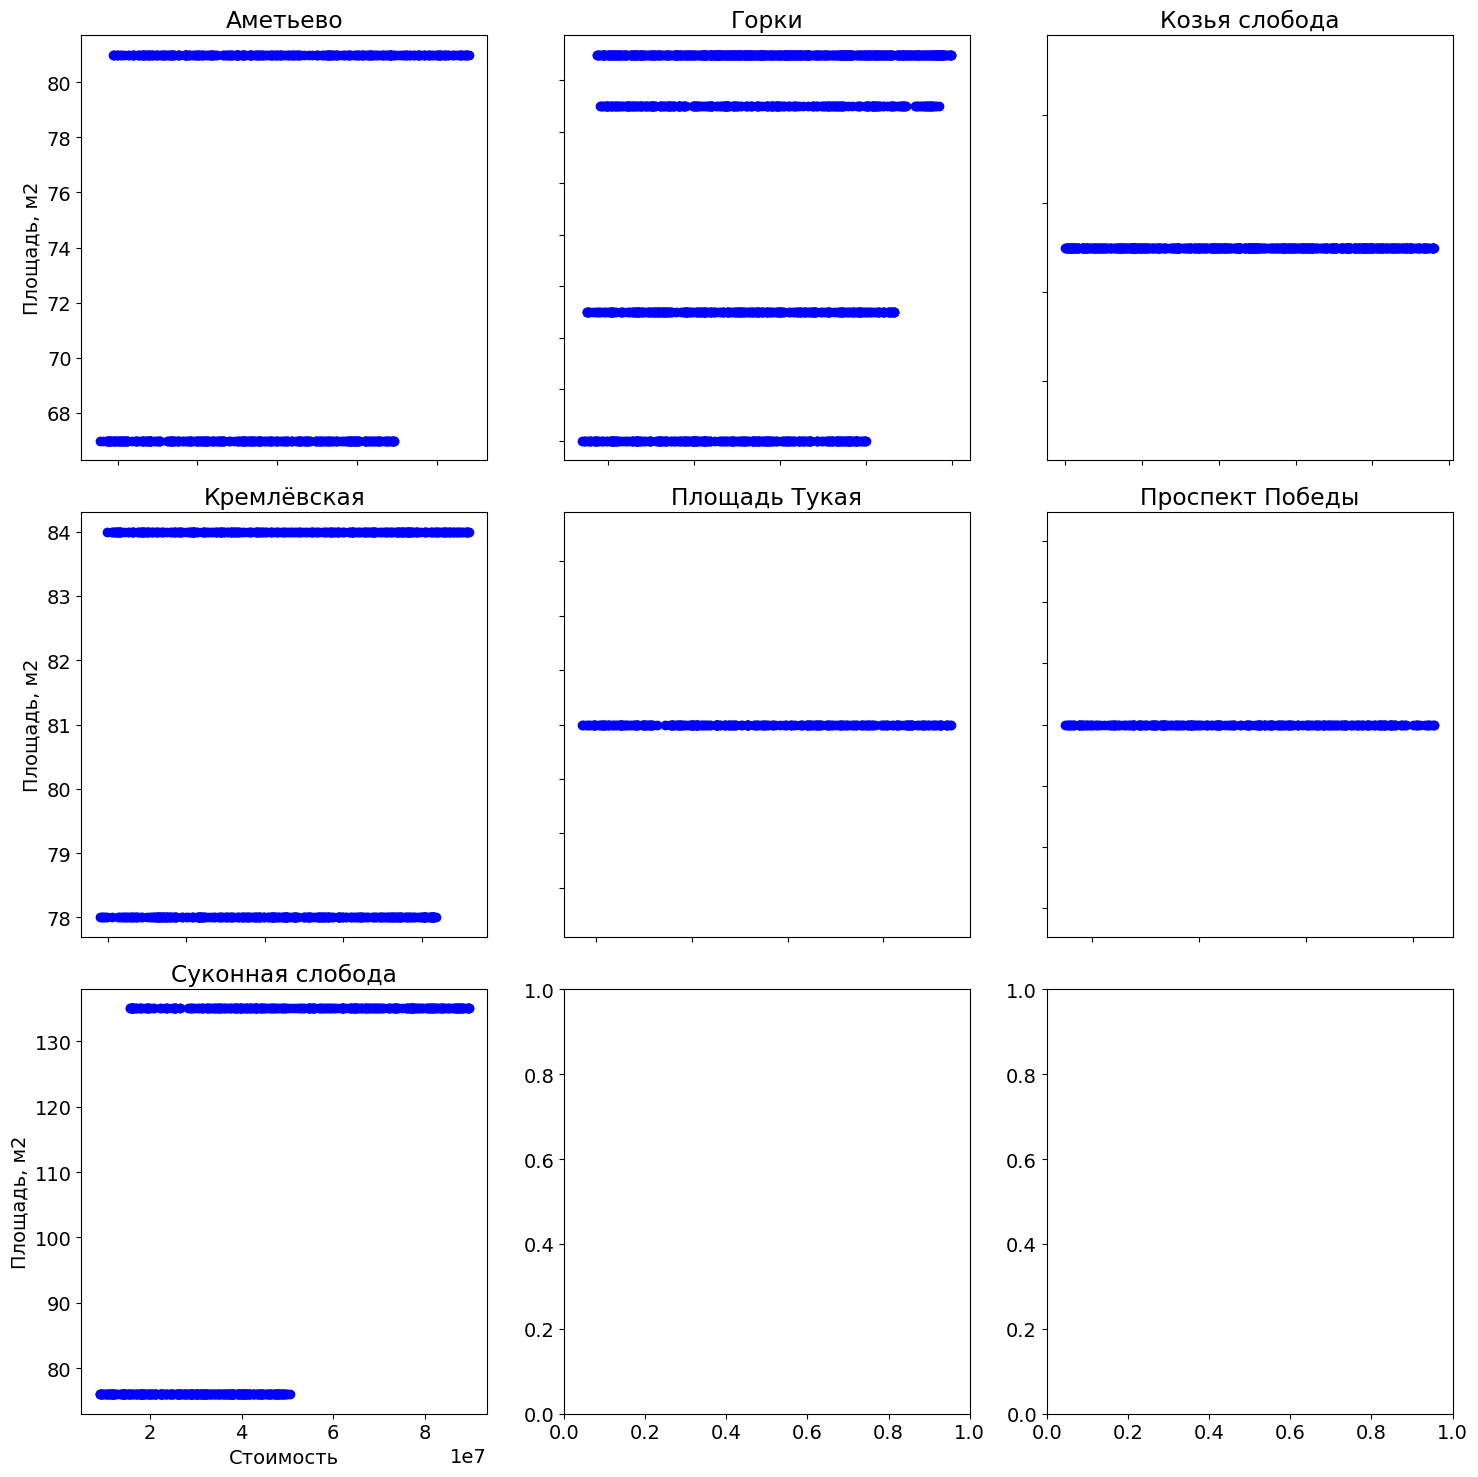

In [47]:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(15,15))

for i, (name, group) in enumerate(df.groupby('metro')):
    axes = axes.flatten()
    axes[i].scatter(group['price'],group['square'], color ='blue')
    axes[i].set_title(name)
    axes[i].set(xlabel='Стоимость', ylabel='Площадь, м2')
    axes[i].label_outer()
    
fig.tight_layout()  

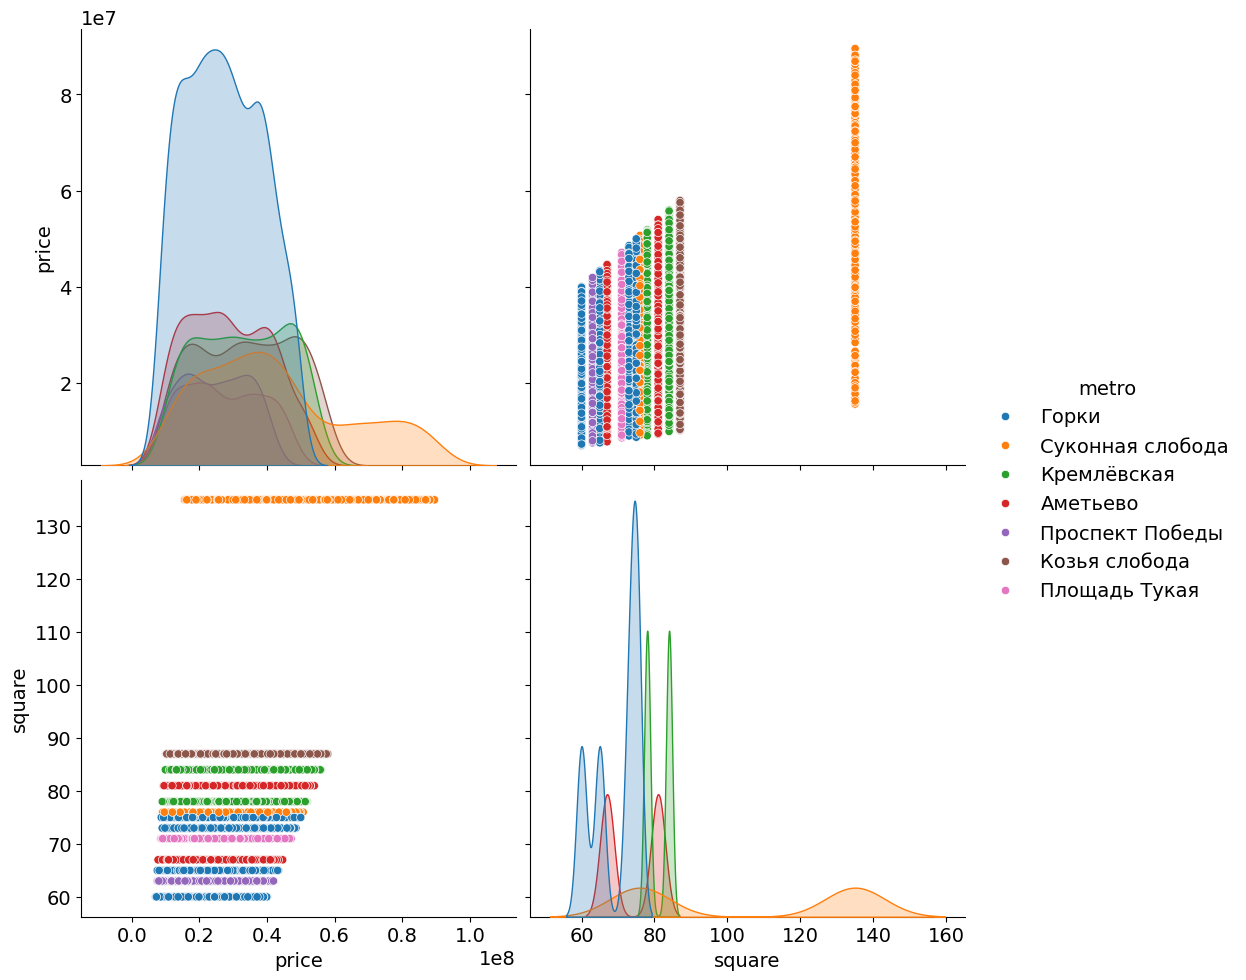

In [48]:
import seaborn as sns
sns.pairplot(vars=["price","square"], data=df, hue="metro", height=5)

array([[<Axes: title={'center': 'Аметьево'}>,
        <Axes: title={'center': 'Горки'}>,
        <Axes: title={'center': 'Козья слобода'}>],
       [<Axes: title={'center': 'Кремлёвская'}>,
        <Axes: title={'center': 'Площадь Тукая'}>,
        <Axes: title={'center': 'Проспект Победы'}>],
       [<Axes: title={'center': 'Суконная слобода'}>, <Axes: >, <Axes: >]],
      dtype=object)

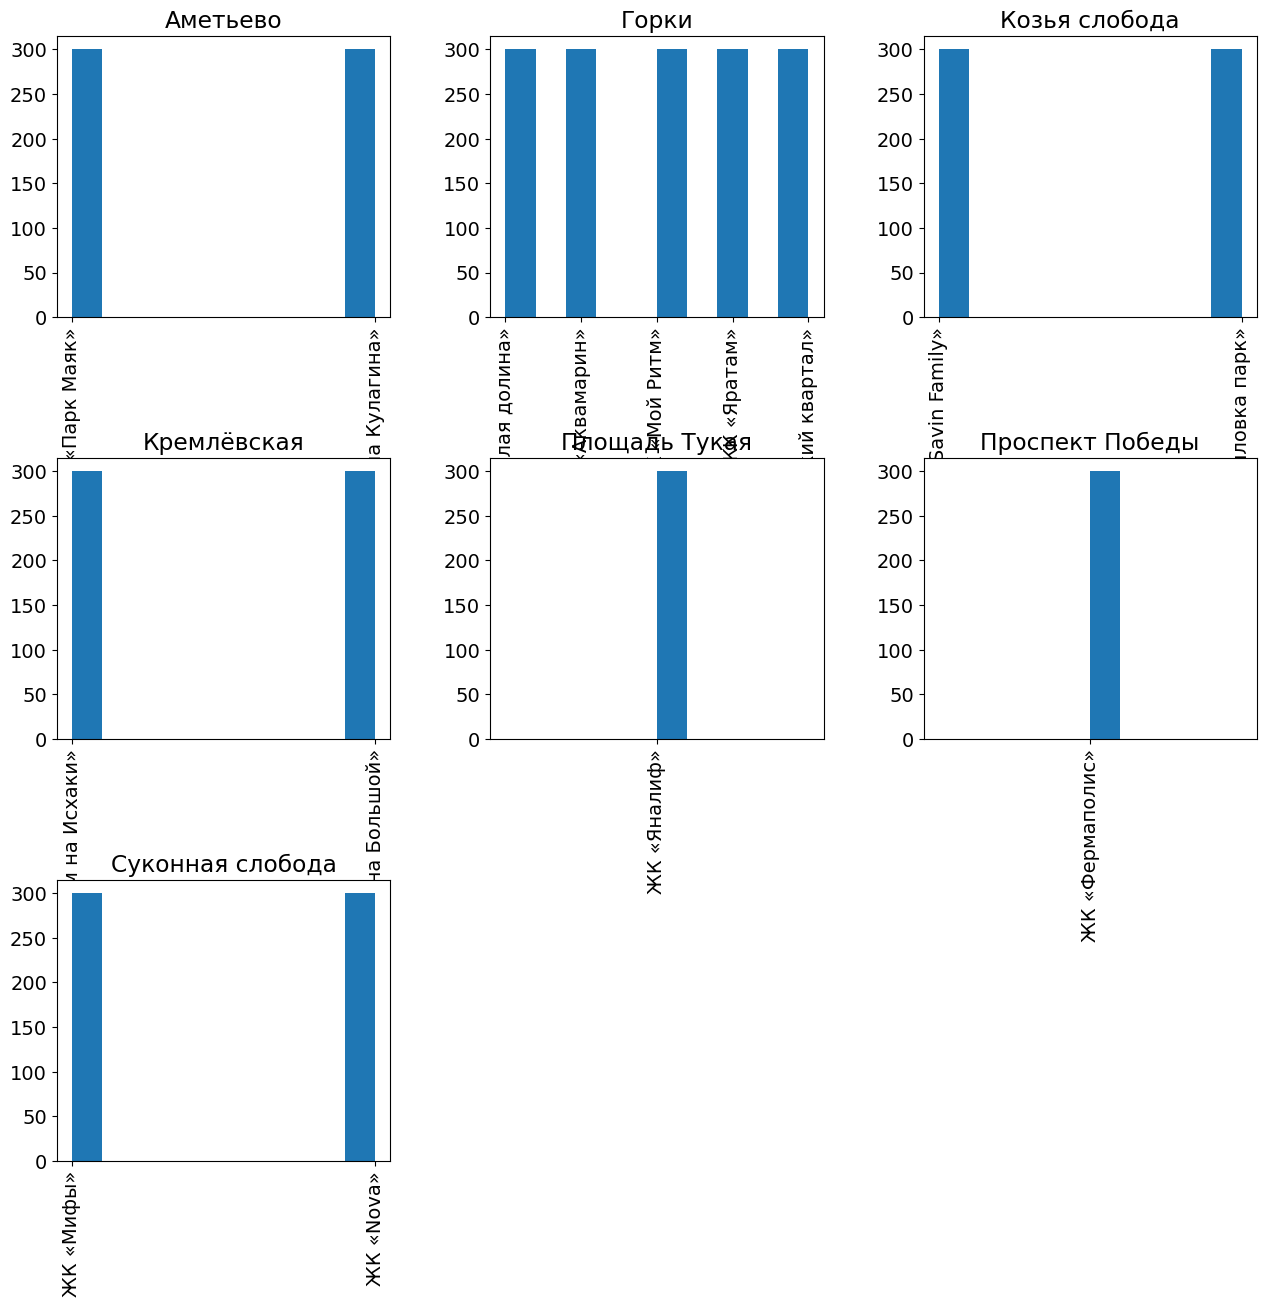

In [49]:
hists = df['complex'].hist(by=df['metro'], figsize=(15, 15), color = "tab:blue", grid = True)
hists

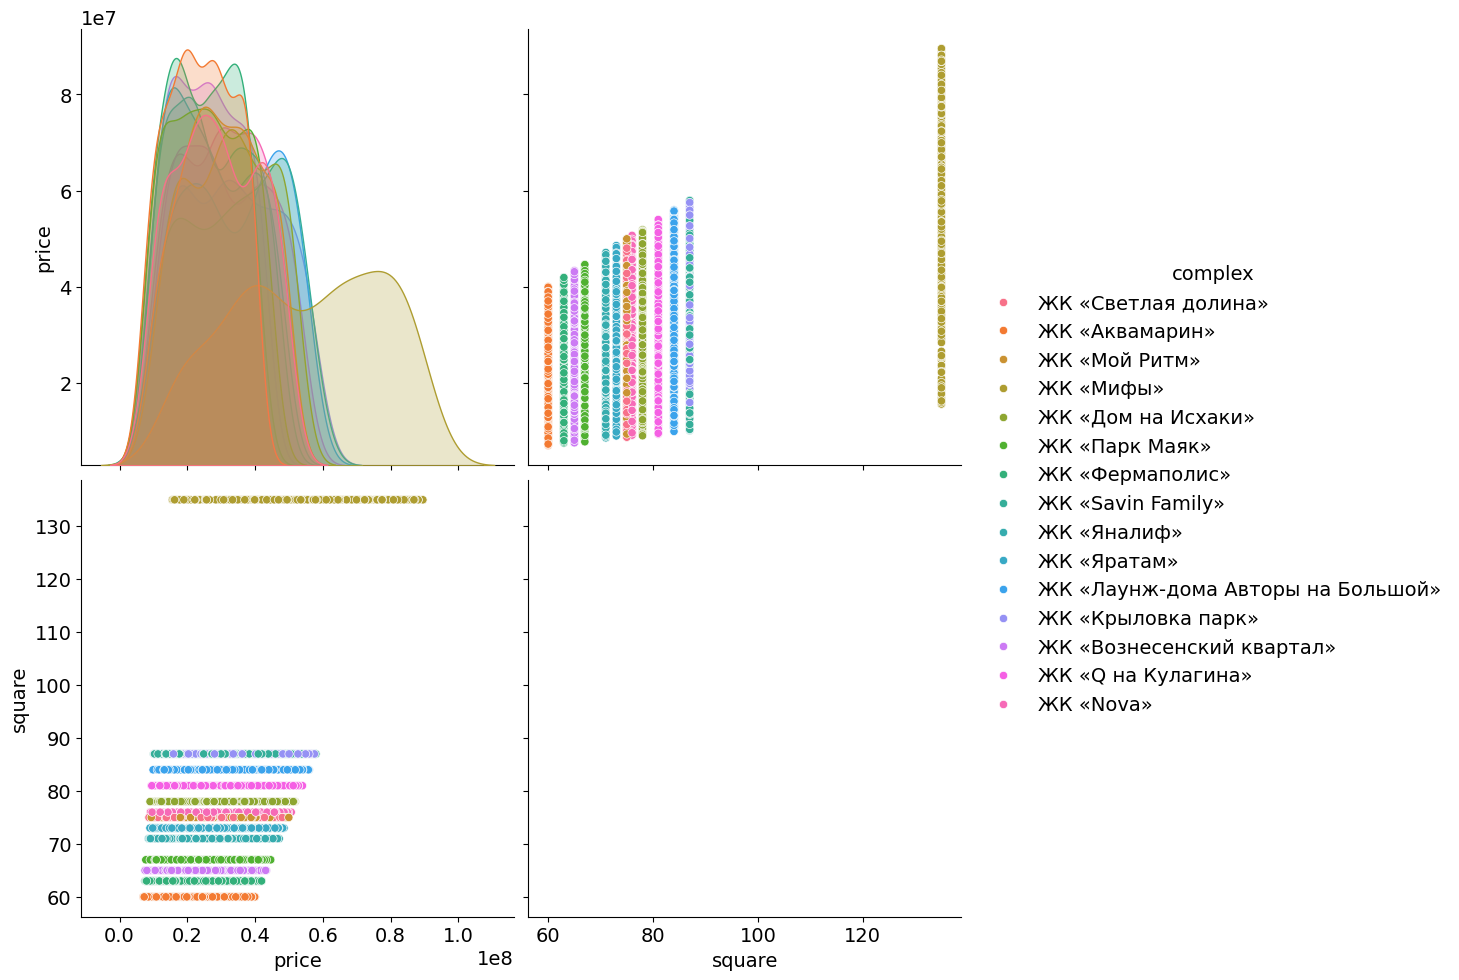

In [50]:
import seaborn as sns
sns.pairplot(vars=["price","square"], data=df, hue="complex", height=5)

In [51]:
df.head()

,index,link,desc,complex,price,price_meter,metro,pub_datetime,address,square
1,0,https://kazan.cian.ru/sale/flat/300752684/,"3-комн. квартира, 75,21 м², 18/19 этажСекция 2...",ЖК «Светлая долина»,37900050,505334,Горки,2024-07 17:22,"Республика Татарстан, Казань, р-н Советский, м...",75
2,1,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,25717320,428622,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60
3,2,https://kazan.cian.ru/sale/flat/301019028/,"3-комн. квартира, 75,29 м², 2/17 этажСекция 6 ...",ЖК «Мой Ритм»,37018950,493586,Горки,2024-07 19:31,"Республика Татарстан, Казань, р-н Советский, м...",75
4,3,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,49591575,367345,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135
5,4,https://kazan.cian.ru/sale/flat/304842045/,"3-комн. квартира, 78,62 м², 2/5 этажСекция 1 •...",ЖК «Дом на Исхаки»,39598962,507679,Кремлёвская,2024-07 16:56,"Республика Татарстан, Казань, р-н Вахитовский,...",78


array([[<Axes: title={'center': 'Аметьево'}>,
        <Axes: title={'center': 'Горки'}>,
        <Axes: title={'center': 'Козья слобода'}>],
       [<Axes: title={'center': 'Кремлёвская'}>,
        <Axes: title={'center': 'Площадь Тукая'}>,
        <Axes: title={'center': 'Проспект Победы'}>],
       [<Axes: title={'center': 'Суконная слобода'}>, <Axes: >, <Axes: >]],
      dtype=object)

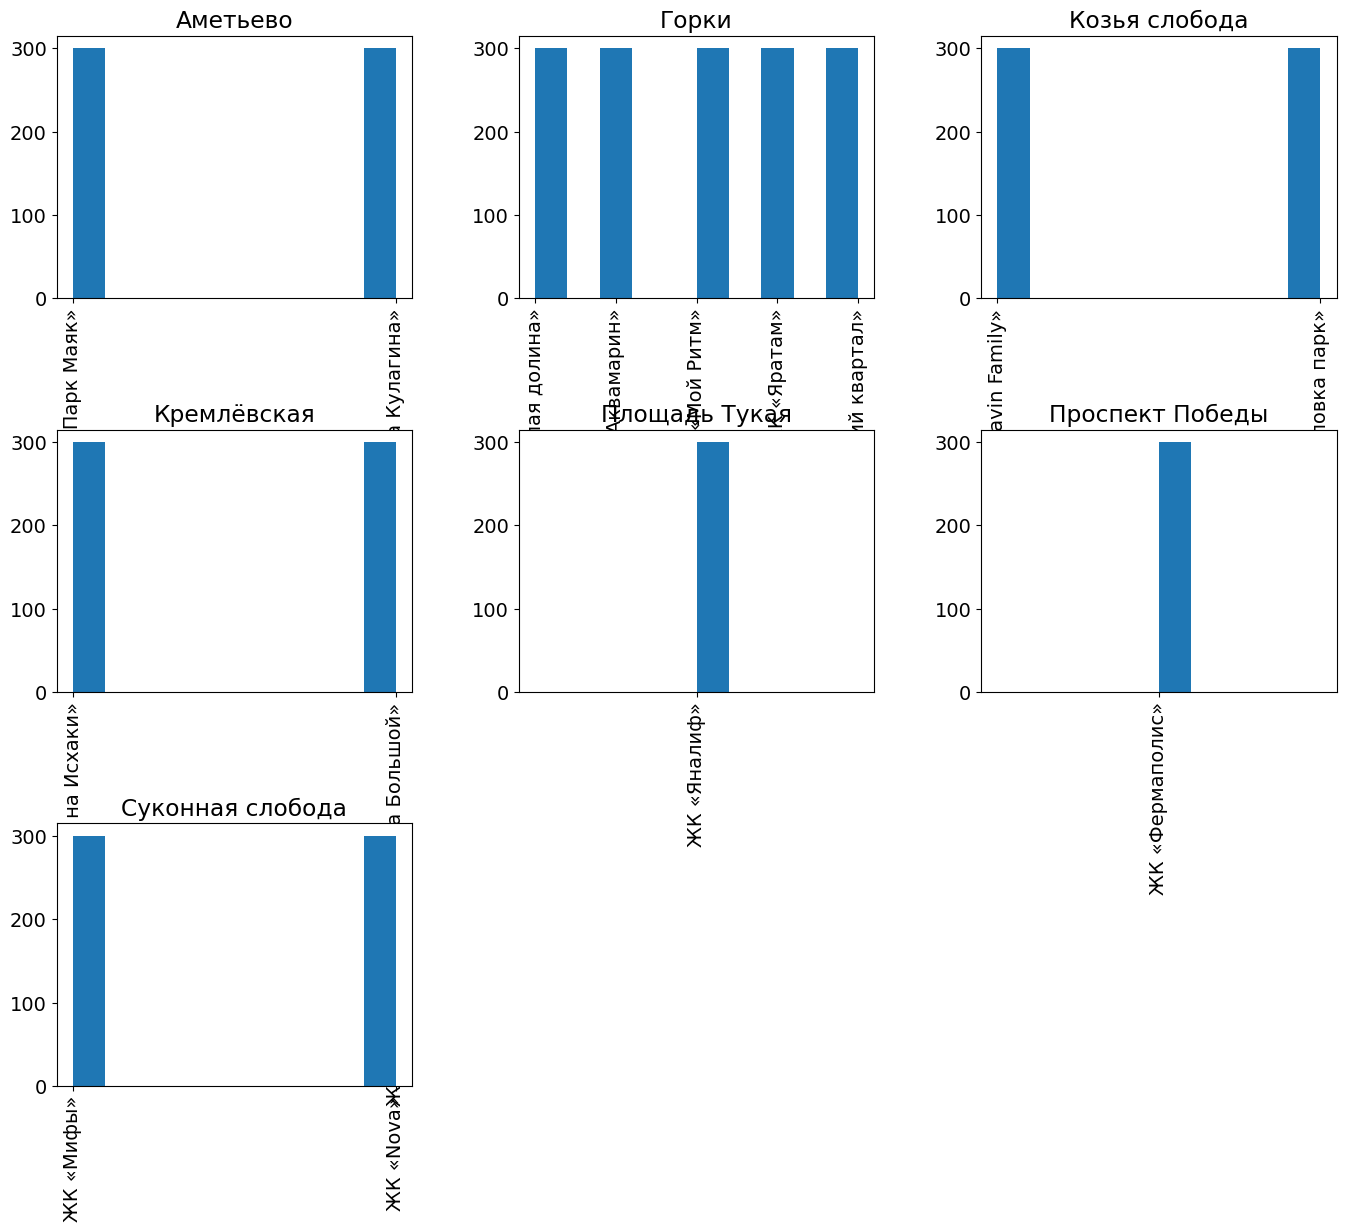

In [52]:
hists = df['complex'].hist(by=df['metro'], figsize=(16, 14), color = "tab:blue", grid = True)
hists

In [53]:
df['room'] = df['desc'].str.split('-').str[0].astype(int)
df.head()

,index,link,desc,complex,price,price_meter,metro,pub_datetime,address,square,room
1,0,https://kazan.cian.ru/sale/flat/300752684/,"3-комн. квартира, 75,21 м², 18/19 этажСекция 2...",ЖК «Светлая долина»,37900050,505334,Горки,2024-07 17:22,"Республика Татарстан, Казань, р-н Советский, м...",75,3
2,1,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,25717320,428622,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60,3
3,2,https://kazan.cian.ru/sale/flat/301019028/,"3-комн. квартира, 75,29 м², 2/17 этажСекция 6 ...",ЖК «Мой Ритм»,37018950,493586,Горки,2024-07 19:31,"Республика Татарстан, Казань, р-н Советский, м...",75,3
4,3,https://kazan.cian.ru/sale/flat/303122643/,"3-комн. квартира, 135,12 м², 3/9 этажСекция 3 ...",ЖК «Мифы»,49591575,367345,Суконная слобода,2024-07 17:19,"Республика Татарстан, Казань, р-н Советский, м...",135,3
5,4,https://kazan.cian.ru/sale/flat/304842045/,"3-комн. квартира, 78,62 м², 2/5 этажСекция 1 •...",ЖК «Дом на Исхаки»,39598962,507679,Кремлёвская,2024-07 16:56,"Республика Татарстан, Казань, р-н Вахитовский,...",78,3


In [54]:
df['room'].unique()

array([3])

In [55]:
df['square'].unique()

array([ 75,  60, 135,  78,  67,  63,  87,  71,  73,  84,  65,  81,  76])

In [56]:
df.dtypes

index           object
link            object
desc            object
complex         object
price            int32
price_meter      int32
metro           object
pub_datetime    object
address         object
square           int32
room             int32
dtype: object

In [60]:
df_p = df[(df['price'] < 12000001) & (df['complex'] != 'ЖК «Мой Ритм»')]


In [61]:
sorted_data = df_p.sort_values(by='price', ascending=True)
sorted_data.head(10)

,index,link,desc,complex,price,price_meter,metro,pub_datetime,address,square,room
1817,1816,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,6974160,116236,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60,3
4187,4186,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,7163700,119395,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60,3
1367,1366,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,7258680,120978,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60,3
4397,4396,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,7279500,121325,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60,3
2287,2286,https://kazan.cian.ru/sale/flat/300939527/,"3-комн. квартира, 63,2 м², 2/14 этажСекция 2 •...",ЖК «Фермаполис»,7502796,119092,Проспект Победы,2024-07 05:18,"Республика Татарстан, Казань, р-н Приволжский,...",63,3
328,327,https://kazan.cian.ru/sale/flat/302597343/,"3-комн. квартира, 65,92 м², 3/22 этажСекция 2 ...",ЖК «Вознесенский квартал»,7524595,115763,Горки,2024-07 15:39,"Республика Татарстан, Казань, р-н Советский, м...",65,3
4093,4092,https://kazan.cian.ru/sale/flat/302597343/,"3-комн. квартира, 65,92 м², 3/22 этажСекция 2 ...",ЖК «Вознесенский квартал»,7526610,115794,Горки,2024-07 15:39,"Республика Татарстан, Казань, р-н Советский, м...",65,3
4303,4302,https://kazan.cian.ru/sale/flat/302597343/,"3-комн. квартира, 65,92 м², 3/22 этажСекция 2 ...",ЖК «Вознесенский квартал»,7539935,115999,Горки,2024-07 15:39,"Республика Татарстан, Казань, р-н Советский, м...",65,3
2953,2952,https://kazan.cian.ru/sale/flat/302597343/,"3-комн. квартира, 65,92 м², 3/22 этажСекция 2 ...",ЖК «Вознесенский квартал»,7575230,116542,Горки,2024-07 15:39,"Республика Татарстан, Казань, р-н Советский, м...",65,3
2357,2356,https://kazan.cian.ru/sale/flat/304664453/,"3-комн. квартира, 60 м², 3/9 этаж",ЖК «Аквамарин»,7618620,126977,Горки,2024-07 11:38,"Республика Татарстан, Казань, р-н Приволжский,...",60,3


In [62]:
df_p['complex'].unique()

array(['ЖК «Фермаполис»', 'ЖК «Яналиф»', 'ЖК «Крыловка парк»',
       'ЖК «Парк Маяк»', 'ЖК «Вознесенский квартал»',
       'ЖК «Светлая долина»', 'ЖК «Яратам»', 'ЖК «Savin Family»',
       'ЖК «Q на Кулагина»', 'ЖК «Аквамарин»',
       'ЖК «Лаунж-дома Авторы на Большой»', 'ЖК «Nova»',
       'ЖК «Дом на Исхаки»'], dtype=object)